# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

### Описание данных
Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.



## Подготовка данных

### Откроем данные, посмотрим на них в разных разрезах

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display 

import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
%matplotlib inline

from sklearn.metrics import roc_auc_score,f1_score,precision_score,recall_score,accuracy_score
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model  import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.impute import KNNImputer

# Формат представления чисел с плавающей точкой в таблицах
pd.options.display.float_format = '{:,.2f}'.format

# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams["figure.figsize"] = 8, 5

#Осуществим подавление вывода  ошибок FutureWarning на этапе 2.1 нашей работы
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#считаем данные
full = pd.read_csv('/datasets/gold_recovery_full.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
train = pd.read_csv('/datasets/gold_recovery_train.csv')

#посмотрим размер датасэтов
for df in train,test,full:
    print(df.shape)

(16860, 87)
(5856, 53)
(22716, 87)


In [4]:
#проверим на дубликаты датасэты
for df in train,test,full:
    print(df.duplicated().sum())   

0
0
0


In [5]:
#посмотрим какие колоники у нас без пропусков
def na_columns(df):
    na_columns=[]
    for column in df.columns:
        if df[column].isna().sum()==0:
            na_columns.append(column)
    print(na_columns)
    return na_columns
na_columns_train = na_columns(train)   

['date', 'primary_cleaner.input.feed_size']


Дубликаты в датасэтах не найдены не найдены. У нас всего 2 колонки без пропусков ['date', 'primary_cleaner.input.feed_size']

### 1.2 Проверим, что эффективность обогащения рассчитана правильно.
Вычислим её на обучающей выборке для признака ``rougher.output.recovery``. Найдем MAE между вашими расчётами и значением признака. Опишем выводы.

In [6]:
def recovery_calc(row):
    C,F,T = row['rougher.output.concentrate_au'],row['rougher.input.feed_au'],row['rougher.output.tail_au']
    if F*(C-T) !=0: 
        recovery = (C*(F-T))/(F*(C-T))*100
    else:
        recovery = np.nan
        global CONUNT
        CONUNT+=1
    return recovery
CONUNT = 0 
train['rougher.output.recovery_calc'] = train.apply(recovery_calc,axis=1)
print('Количество делений на ноль составило ',CONUNT)
# количество прогнозов с NaN получилось
print ('Количество прогнозов с NaN получилось',train['rougher.output.recovery_calc'].isna().sum())
print ('Количество NaN в эффективноси обогащения чернового концентрата ',train['rougher.output.recovery'].isna().sum())

Количество делений на ноль составило  63
Количество прогнозов с NaN получилось 2313
Количество NaN в эффективноси обогащения чернового концентрата  2573


In [7]:
recovery_calc = train.copy()
recovery_calc.dropna(subset = ['rougher.output.recovery_calc','rougher.output.recovery'],inplace=True)
print ('Количество прогнозов с NaN получилось',recovery_calc['rougher.output.recovery_calc'].isna().sum())
print ('Количество NaN в эффективноси обогащения чернового концентрата ',recovery_calc['rougher.output.recovery'].isna().sum())
recovery_calc[['rougher.output.recovery','rougher.output.recovery_calc']]
# вычислим значение метрики МАЕ, посмотрим на сколько точно была вычислена эффективность обогащения чернового концентрата 
mean_absolute_error(recovery_calc['rougher.output.recovery'],recovery_calc['rougher.output.recovery_calc'])

Количество прогнозов с NaN получилось 0
Количество NaN в эффективноси обогащения чернового концентрата  0


9.444891926100695e-15

Значение МАЕ очень невысокое, значит в исходных данных эффективность обогащения цернового концентрата посчитана верно. Можно продолжать дальше. 

### 1.3. Проанализируем признаки, недоступные в тестовой выборке. 


In [8]:
#Посмотрим различем между трейном и тестом
train_set = set(train.columns.to_list())
test_set = set(test.columns.to_list())
full_set = set(full.columns.to_list())

#сравним full и тест
test_diff_full = list(train_set ^ full_set)
display(train[test_diff_full])

#сравним столбцы с тествовой выборкой и покажем те столбыцы в трэйне, которых нет в тесте
test_diff_train = list(train_set ^ test_set)
display(train[test_diff_train])
print(train[test_diff_train].sort_index(axis=1).info())

# посмотрим на столбцы, которые есть в трейне и тесте
train_and_test = list(train_set & test_set)
display('Количество признаков, которые есть в трэйне и тесте равно',len(train_and_test))



,rougher.output.recovery_calc
0,87.11
1,86.84
2,86.84
3,87.23
4,86.69
...,...
16855,89.57
16856,87.72
16857,88.89
16858,89.86


,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.output.tail_pb,rougher.output.recovery_calc,rougher.calculation.au_pb_ratio,primary_cleaner.output.concentrate_ag,primary_cleaner.output.tail_pb,final.output.tail_sol,final.output.concentrate_ag,final.output.tail_au,final.output.tail_pb,...,rougher.calculation.floatbank10_sulfate_to_au_feed,final.output.recovery,final.output.concentrate_pb,rougher.output.recovery,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,primary_cleaner.output.tail_ag,rougher.output.tail_au,rougher.output.tail_sol,primary_cleaner.output.tail_sol
0,"3,520.34",0.51,87.11,2.84,8.55,2.53,16.90,6.06,2.14,0.90,...,"3,481.78",70.54,9.89,87.11,2.61,14.50,14.94,1.17,19.15,7.48
1,"3,489.98",0.54,86.84,2.86,8.56,3.05,16.63,6.03,2.22,0.93,...,"3,498.37",69.27,9.97,86.84,2.49,14.27,16.25,1.18,18.97,6.73
2,"3,502.36",0.55,86.84,2.95,8.60,3.12,16.21,6.06,2.26,0.95,...,"3,495.35",68.12,10.21,86.84,2.46,14.12,16.49,1.16,18.81,6.47
3,"3,499.16",0.54,87.23,3.00,7.22,2.96,16.53,6.05,2.15,0.88,...,"3,498.58",68.35,9.98,87.23,2.32,13.73,16.02,1.08,19.33,6.84
4,"3,506.68",0.52,86.69,3.17,9.09,3.11,16.53,6.15,2.06,0.79,...,"3,494.80",66.93,10.14,86.69,2.33,14.08,16.48,1.01,19.27,6.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,"2,499.18",0.61,89.57,1.16,6.56,6.53,10.40,3.22,1.53,3.14,...,"2,497.65",73.76,11.36,89.57,0.00,0.00,22.85,0.75,16.67,3.93
16856,"2,518.55",0.65,87.72,1.17,6.61,6.63,10.55,3.20,1.61,3.13,...,"2,614.40",69.05,11.35,87.72,0.00,0.00,23.00,0.77,16.96,4.09
16857,"2,510.14",0.64,88.89,1.13,7.13,6.28,11.12,3.11,1.60,2.91,...,"2,510.81",67.00,11.43,88.89,0.00,0.00,22.30,0.69,18.32,4.46
16858,"2,507.72",0.63,89.86,1.12,7.49,6.25,10.46,3.37,1.60,2.82,...,"2,507.57",65.52,11.63,89.86,0.00,0.00,22.71,0.57,19.42,3.56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 35 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_au                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
primary_cleaner.output.concentrate_ag                 16778 non-null float64
primary_cleaner.output.concentrate_au                 16778 non-null float64
primary_cleaner.output.concentrate_pb       

'Количество признаков, которые есть в трэйне и тесте равно'

53

Проанализируем признаки, которые нам не доступны на тесте:
-	rougher — флотация
    - calculation — расчётные характеристики
        - au_pb_ratio 
        - floatbank10_sulfate_to_au_feed    
        - floatbank11_sulfate_to_au_feed 
        - sulfate_to_au_concentrate
    - output — параметры продукта
        - concentrate_ag
        - concentrate_au
        - concentrate_au_calc
        - concentrate_pb
        - concentrate_sol
        - recovery
        - tail_ag 
        - tail_au
-	primary_cleaner — первичная очистка
    - output — параметры продукта и хвосты (tail - отвальные хвосты, т.е. отходы производства)
        - primary_cleaner.output.concentrate_ag                 
        - primary_cleaner.output.concentrate_au                 
        - primary_cleaner.output.concentrate_pb                 
        - primary_cleaner.output.concentrate_sol                
        - primary_cleaner.output.tail_ag                        
        - primary_cleaner.output.tail_au                        
        - primary_cleaner.output.tail_pb                        
        - primary_cleaner.output.tail_sol  
-	secondary_cleaner — вторичная очистка
    - output — параметры продукта
        - secondary_cleaner.output.tail_ag                      
        - secondary_cleaner.output.tail_au                      
        - secondary_cleaner.output.tail_pb                      
        - secondary_cleaner.output.tail_sol 
-	final — финальные характеристики
    - output — параметры продукта
        - final.output.concentrate_ag                           
        - final.output.concentrate_au                           
        - final.output.concentrate_pb                           
        - final.output.concentrate_sol                          
        - final.output.recovery                                 
        - final.output.tail_ag                                 
        - final.output.tail_au                                  
        - final.output.tail_pb                                  
        - final.output.tail_sol 



Мы посмотрели на различие в данных между трейном и тестом. Выявили 34 колонки. Посмотрели что нет различий в колонках между трэйном и фуллом. По условиям задачи на тесте меньше данных, т.к.часть параметров после флотации нам не известна и эти данные нельзя будет использовать для обучения модели. 

В основном пропущены - ``output — параметры продукта``, которые нельзя получить сразу посл флотации.


In [9]:
for element in sorted(list(train_set & test_set)):
                    print(element)
#print(list(train_set & test_set))

date
primary_cleaner.input.depressant
primary_cleaner.input.feed_size
primary_cleaner.input.sulfate
primary_cleaner.input.xanthate
primary_cleaner.state.floatbank8_a_air
primary_cleaner.state.floatbank8_a_level
primary_cleaner.state.floatbank8_b_air
primary_cleaner.state.floatbank8_b_level
primary_cleaner.state.floatbank8_c_air
primary_cleaner.state.floatbank8_c_level
primary_cleaner.state.floatbank8_d_air
primary_cleaner.state.floatbank8_d_level
rougher.input.feed_ag
rougher.input.feed_au
rougher.input.feed_pb
rougher.input.feed_rate
rougher.input.feed_size
rougher.input.feed_sol
rougher.input.floatbank10_sulfate
rougher.input.floatbank10_xanthate
rougher.input.floatbank11_sulfate
rougher.input.floatbank11_xanthate
rougher.state.floatbank10_a_air
rougher.state.floatbank10_a_level
rougher.state.floatbank10_b_air
rougher.state.floatbank10_b_level
rougher.state.floatbank10_c_air
rougher.state.floatbank10_c_level
rougher.state.floatbank10_d_air
rougher.state.floatbank10_d_level
rougher.st

In [10]:
#исходя из условий задачи, добвим данные из таблицы фулл
full_recovery = full[['date','rougher.output.recovery','final.output.recovery']].copy()
test_from_full = full_recovery.query('date in @test.date')

#добавим данные recovery к тесту
test= test.merge(test_from_full,on='date')
display(test[-5:])

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
5851,2017-12-31 19:59:59,173.96,15.96,8.07,0.90,"1,401.93",-499.73,"1,401.44",-499.19,"1,399.81",...,12.07,-499.67,7.98,-499.52,5.93,-499.97,8.99,-499.76,95.17,68.92
5852,2017-12-31 20:59:59,172.91,16.00,8.07,0.90,"1,447.08",-494.72,"1,448.85",-465.96,"1,443.89",...,13.37,-499.12,9.29,-496.89,7.37,-499.94,8.99,-499.90,94.58,68.44
5853,2017-12-31 21:59:59,171.14,15.99,8.07,1.17,"1,498.84",-501.77,"1,499.57",-495.52,"1,502.75",...,15.10,-499.94,10.99,-498.35,9.02,-500.04,8.98,-497.79,93.02,67.09
5854,2017-12-31 22:59:59,179.70,15.44,8.07,1.50,"1,498.47",-500.48,"1,497.99",-519.20,"1,496.57",...,15.03,-499.72,11.01,-499.99,9.01,-499.94,9.01,-500.15,92.60,68.06
5855,2017-12-31 23:59:59,181.56,15.00,8.07,1.62,"1,498.10",-499.80,"1,501.74",-505.15,"1,499.54",...,14.91,-499.95,10.99,-500.66,8.99,-500.34,8.99,-500.76,91.18,71.70


### 1.4. Проведем предобработку данных

In [11]:
#Заметим что нам попадаются нули, это очевидно пропуски, заменим их на NaN
train = train.replace({'0':np.nan, 0:np.nan})
test = test.replace({'0':np.nan, 0:np.nan})#,0.01:np.nan
#train= train.replace(to_replace =0.01,value =np.nan)
'''заметим так же что есть значения 0.01, что тоже можно считать нулем, преобразуем эти значения тоже в NaN
def replace_value(df):
    numeric = df.select_dtypes(include=np.float64).columns.tolist()
    #numeric = list( set(numeric) - set(['primary_cleaner.input.sulfate','primary_cleaner.input.xanthate','rougher.input.floatbank11_xanthate']))
    for column in df[numeric].columns:
        #df[column] = np.where((train_copy[column]< 0.1), np.nan, df[column])
        df.loc[train_copy[column] < 1,column] = np.nan
       
replace_value(train)
replace_value(test)'''
print()

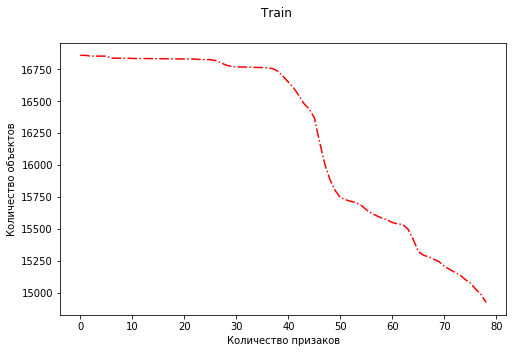

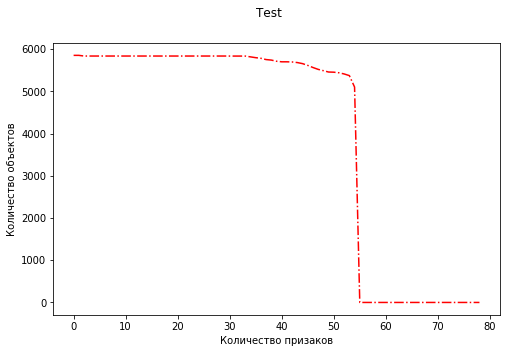

In [12]:
# посмотрим зависимость количество признаков и объектов  
def threshold_miss_value(df,suptitle):
    threshold_miss_value = []
    for n in range(1,80):
        threshold_miss_value.append(df.dropna(axis=0,thresh=n).shape[0])
    plt.plot(threshold_miss_value,color='r',linestyle='dashdot');
    plt.xlabel('Количество призаков')
    plt.ylabel('Количество объектов')
    plt.suptitle(suptitle)
    plt.show()
# посмотрим количество признаков для трейна и теста
threshold_miss_value(train,'Train')
threshold_miss_value(test,'Test')

Мы попытались найти оптимальное количество удаляемых строк. Попытались найти те строки, которые нет смысла заполнять пропусками, где пропущено слишком много признаков. Мы остановились на значении 65 столбцов для трейна и 50 столбцов для теста.

date    datetime64[ns]
dtype: object


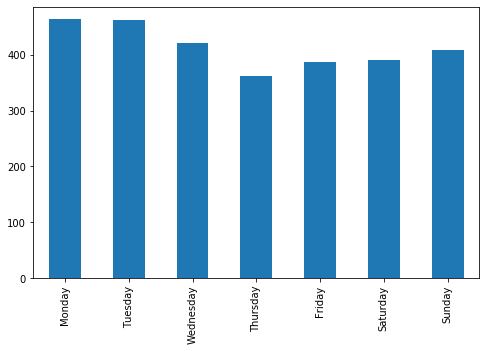

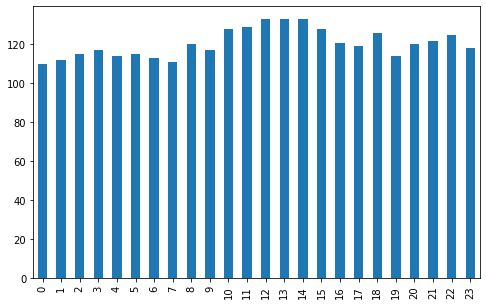

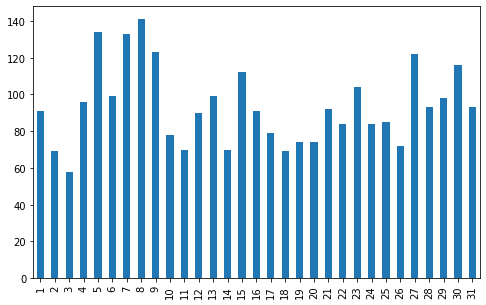

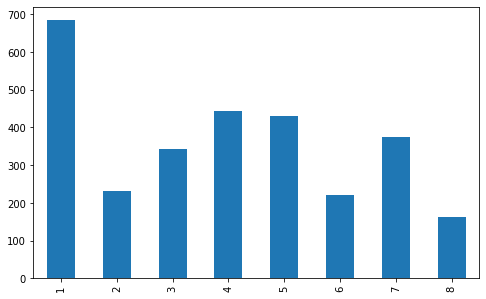

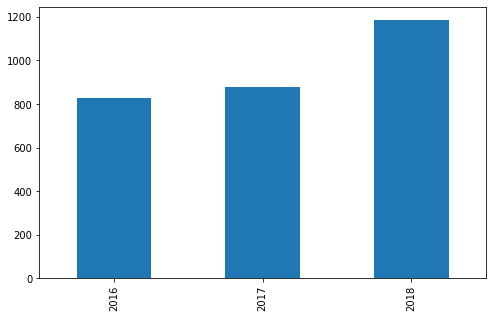

In [13]:
# переведем столбец с датой в тип datetime "дата"
train['date'] = pd.to_datetime(train['date'], errors='coerce')
print(train.dtypes[:1])
train['hour'] = pd.DatetimeIndex(train['date']).hour
train['day_month'] = pd.DatetimeIndex(train['date']).day
train['month'] = pd.DatetimeIndex(train['date']).month
train['year'] = pd.DatetimeIndex(train['date']).year

# Подготовим словарь для дней недели и заполним по нему строки
dw_mapping={
    0: 'Monday', 
    1: 'Tuesday', 
    2: 'Wednesday', 
    3: 'Thursday', 
    4: 'Friday',
    5: 'Saturday', 
    6: 'Sunday'
} 
train['day_week']=pd.DatetimeIndex(train['date']).weekday.map(dw_mapping)

order = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday',    'Saturday',    'Sunday']
#посмотрим на пропущенные  данные в разрезе недли
day_train = train[train['rougher.output.recovery'].isnull()]['day_week'].value_counts()#set_index('day_week').loc[order]['date']
# упорядочим объект Series
day_train = pd.Series(day_train).loc[order]
ax =day_train.plot(kind='bar');
plt.show()

#посмотрим на пропущенные  данные в разрезе месяца
def show_missing_values(column):
    df= pd.Series(train[train['rougher.output.recovery'].isnull()][column].value_counts()).sort_index()
    # упорядочим объект Series
    ax =df.plot(kind='bar');
    plt.show()

# посмотрим на пропуски в разрезе дня,месяца и года
show_missing_values('hour')
show_missing_values('day_month')
show_missing_values('month')
show_missing_values('year')

Годы:

- Как мы видим больше всего пропусков было в 2018 году, примерно на 30% больше чем в 2016 и 2017 годах.

Месяцы:
- Пропуски в данных случались в первой половине года, особенно в январе очень много пропусков. Начиная с сенятбря пропусков небыло вообще.

Дни месяца:
- В середине месяца пропусков немного больше

Дни недели 
- в начале недели пропусков тоже было больше

In [14]:
#посмотрим столбцы в которых бльше всего пропусков 
def missing_values(df):
    display((df.isnull().sum().sort_values(ascending=False)/len(df)*100)[:20])

Больше всего пропусков -  в столбцах типа ``rougher.output``. Максимальное количество незаполненых пропусков  в трейне и тесте 25%.

In [15]:
# по условиям задачи часть данных находится в таблице full. Попробуем дозаполнить данные
#train подготовка данных к update
train_from_full = full.query('date in @train.date').reset_index(drop=True)
train.reset_index(drop=True,inplace=True)

#test подготовка данных к update
test_from_full = full[train_and_test].query('date in @test.date').reset_index(drop=True)
test.reset_index(drop=True,inplace=True)

#сделаем update с заполнением только NaN
train.update(train_from_full,overwrite=False)
test.update(test_from_full,overwrite=False)
print(train.shape)
print(test.shape)

#можно так же пробовать #test = test.combine_first(test_from_full)

#Заполним опять нули NaN
train = train.replace({'0':np.nan, 0:np.nan})
test = test.replace({'0':np.nan, 0:np.nan})

#проверка процента пропусков
missing_values(train)
missing_values(test)

(16860, 93)
(5856, 55)


secondary_cleaner.output.tail_sol        25.41
rougher.output.recovery                  17.16
rougher.output.recovery_calc             15.62
secondary_cleaner.output.tail_pb         14.20
secondary_cleaner.output.tail_ag         14.13
secondary_cleaner.output.tail_au         14.12
rougher.output.tail_ag                   13.35
rougher.output.tail_sol                  13.34
rougher.output.tail_au                   13.34
rougher.input.floatbank11_xanthate       11.29
primary_cleaner.output.concentrate_sol   11.07
final.output.tail_pb                     10.92
primary_cleaner.output.tail_sol          10.85
final.output.tail_sol                    10.69
final.output.tail_au                     10.23
final.output.tail_ag                     10.23
rougher.output.concentrate_sol            9.82
primary_cleaner.output.tail_pb            9.77
rougher.output.tail_pb                    9.76
final.output.concentrate_sol              9.69
dtype: float64

rougher.output.recovery                    11.01
final.output.recovery                       8.61
rougher.input.feed_sol                      7.45
rougher.input.feed_au                       6.57
rougher.input.feed_ag                       6.57
rougher.input.feed_pb                       6.57
rougher.input.floatbank11_xanthate          6.03
primary_cleaner.input.sulfate               5.16
primary_cleaner.input.depressant            4.85
rougher.input.floatbank10_sulfate           4.39
secondary_cleaner.state.floatbank3_a_air    2.97
primary_cleaner.input.xanthate              2.83
secondary_cleaner.state.floatbank2_b_air    2.75
secondary_cleaner.state.floatbank3_b_air    2.63
secondary_cleaner.state.floatbank4_a_air    2.63
secondary_cleaner.state.floatbank4_b_air    2.63
rougher.input.floatbank10_xanthate          2.10
primary_cleaner.state.floatbank8_a_air      1.86
primary_cleaner.state.floatbank8_b_air      1.78
primary_cleaner.state.floatbank8_d_air      1.09
dtype: float64

Ничего не поменялось, в этом плане нам таблица full ничего не дала.

In [16]:
#посмотрим есть ли строки с пропусками
print(train.shape)
print(train.dropna(axis=0,how='all').shape)

print(test.shape)
print(test.dropna(axis=0,how='all').shape)

#проверим на дубликаты датасэты
for df in train,test,full:
    print('Количество дубликатов равно',df.duplicated().sum())   

(16860, 93)
(16860, 93)
(5856, 55)
(5856, 55)
Количество дубликатов равно 0
Количество дубликатов равно 0
Количество дубликатов равно 0


Полнострочных пропусков нет, дубликатов тоже нет. 

In [17]:
# проанализируем целевые признаки rougher и final .output.recovery
#(train[train['rougher.output.recovery'].isna()])[['date','rougher.output.tail_ag']][200:260]
train[train['rougher.input.floatbank11_xanthate'].isna()][['date','rougher.output.recovery','final.output.recovery']][:50]

,date,rougher.output.recovery,final.output.recovery
98,2016-01-19 02:00:00,26.28,58.02
99,2016-01-19 03:00:00,nan,nan
100,2016-01-19 04:00:00,nan,nan
101,2016-01-19 05:00:00,nan,nan
102,2016-01-19 06:00:00,nan,nan
103,2016-01-19 07:00:00,nan,nan
104,2016-01-19 08:00:00,nan,nan
105,2016-01-19 09:00:00,nan,nan
106,2016-01-19 10:00:00,nan,nan
107,2016-01-19 11:00:00,nan,nan


Посмотрев на выбросы в разных разрезах  мы заметили следующие закономерности:
1. Пропуски в признаках (хвосты) 
    - rougher.output.tail_ag                     
    - rougher.output.tail_sol                    
    - rougher.output.tail_au 
связаны с пропуском в целевом признаке ``rougher.output.recovery``. Их меньше, т.к. во время переходных процессов остановки/пропадания данных выработки значения этих параметров появлялись, скорее всего они брались с предыдущего цикла расчета(часа).
    

In [18]:
# посмотрим сколько дней подряд простаивало производство.
# будем записывать сколько NaN было подряд
def count_missin_nan(values):
    list_day_stop = []
    previous_value = values[0]
    count = 0 
    for _index,value in values.items():
        #распечатаем значения счетчика и признака
        #print(value,count)
        if np.isnan(value):
            #print('f')
            count+=1
            previouse_value = value
            #print(previouse_value)
        else:            
            #print('f')
            
            if count!=0:
                list_day_stop.append(count)
            count=0
            previous_value = value
            
    return list_day_stop
list_day_stop = pd.Series(count_missin_nan(train['rougher.output.recovery']))

In [19]:
#посмотрим сколько длились простои и их количество
_df = pd.DataFrame(list_day_stop.value_counts().sort_index(ascending=False).reset_index())
_df.columns = ('stop_hour','quantity')
_df['stop_day'] = _df['stop_hour']/24
_df[['stop_day','quantity']]

,stop_day,quantity
0,9.08,1
1,6.58,1
2,6.46,1
3,5.46,1
4,5.29,1
5,5.12,1
6,4.33,1
7,4.04,1
8,3.21,1
9,3.12,1


Как мы видим, один несколько раз производство простаивало вплоть до 9 дней. Много мелких остановов(до 2-3 часов). Но предположим что это связано с локальными сбоями АСУТП. Можно бы было почистить данные на основании этой информации, но это довольно трудоемко в рамках данного проекта.

In [20]:
# удалим данные  в трейне где заполнено не менее 65 признаков  
# удалим данные  в трейне где заполнено не менее 50 признаков 
train.dropna(axis=0,thresh=65,inplace=True)
test.dropna(axis=0,thresh=50,inplace=True)

# посмотрим, как изменились показатели
#train.isnull().sum().sort_values(ascending=False)[:50]
missing_values(train)
missing_values(test)

secondary_cleaner.output.tail_sol        19.25
rougher.output.recovery                  10.31
rougher.output.recovery_calc              8.64
secondary_cleaner.output.tail_pb          7.13
secondary_cleaner.output.tail_ag          7.05
secondary_cleaner.output.tail_au          7.04
rougher.output.tail_ag                    6.19
rougher.output.tail_sol                   6.18
rougher.output.tail_au                    6.18
rougher.input.floatbank11_xanthate        4.74
primary_cleaner.output.concentrate_sol    4.50
hour                                      4.17
final.output.tail_pb                      3.60
primary_cleaner.output.tail_sol           3.49
rougher.state.floatbank10_e_air           3.37
final.output.tail_sol                     3.35
rougher.output.concentrate_sol            3.15
final.output.concentrate_sol              3.12
final.output.tail_ag                      2.85
final.output.tail_au                      2.85
dtype: float64

rougher.output.recovery                    4.61
final.output.recovery                      2.01
rougher.input.feed_sol                     0.82
rougher.input.floatbank11_xanthate         0.68
secondary_cleaner.state.floatbank3_a_air   0.26
primary_cleaner.input.depressant           0.16
rougher.input.floatbank11_sulfate          0.16
primary_cleaner.input.sulfate              0.13
primary_cleaner.input.xanthate             0.13
secondary_cleaner.state.floatbank2_b_air   0.09
rougher.input.floatbank10_sulfate          0.09
rougher.input.feed_rate                    0.09
secondary_cleaner.state.floatbank2_a_air   0.05
rougher.input.floatbank10_xanthate         0.02
rougher.input.feed_au                      0.00
rougher.input.feed_size                    0.00
rougher.input.feed_ag                      0.00
rougher.input.feed_pb                      0.00
rougher.state.floatbank10_a_level          0.00
primary_cleaner.state.floatbank8_d_level   0.00
dtype: float64

In [21]:
train['rougher.output.recovery'].isnull().sum()
# Количество пропусков в целевом признаке сократилось с 2800 до 1600
# теперь можем приступить к заполнениею

1605

In [22]:
#удалим пропуски с целевыми признаками
train = train.dropna(subset = ['rougher.output.recovery','final.output.recovery'])
test = test.dropna(subset = ['rougher.output.recovery','final.output.recovery'])

In [23]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [24]:
#скопируем трейн для анализа
train_copy = train.copy()

#в трейне оставим только те признаки, которые можно использовать в модели для обучения 
train_set = set(train.columns.to_list())
test_set = set(test.columns.to_list())
train_and_test = list(train_set & test_set)
train = train[train_and_test]
print(train.shape,test.shape)

(9857, 55) (5105, 55)


Промежуточные итоги:
- проверили датасэты на дубликаты 
- Проанализировали различия в train и test по сравнению с исходными данными full. Добавили целевые признаки в test, и убрали признаки на которых нельзя обучать модель из train
- проверили, что обогащение рассчитывается корректно
- посчитали значение метрики MAE между нашими расчетами и табличными данными test.
- проанализировали признаки, недоступные на тестовой выборке
- подобрали порог для удаления данных (чтобы не удалить много лишнего)
- поменяли нули  на NAN чтобы можно было в дальнейшем работать с пропусками
- поанализировали данные в разрезе Года, Месяца, дней месяца, дней недели, часа. Чтобы попытаться выявить причины простоя
- Посмотрели на время просто
- заполнили пропуски методом KNN imputer


## Анализ данных

### 2.1 Исследование изменения концентрации элементов на каждом этапе  

In [25]:
#Посмотритм, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки
#выберем инетересующие нас признаки отбросив хвосты и взяв только выход
for column in train_copy.columns:
    for metall in ['au','ag','pb']:        
        if (column.find(metall))!=-1:
            if column.find('output') > 0 and column.find('tail')==-1:
                print(column)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_au
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_au


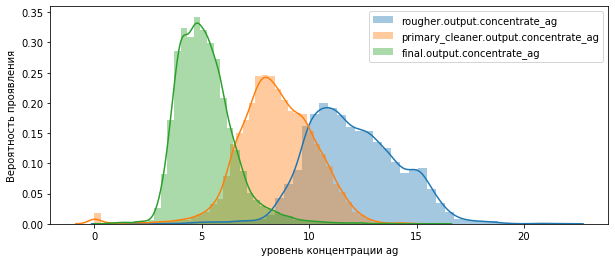

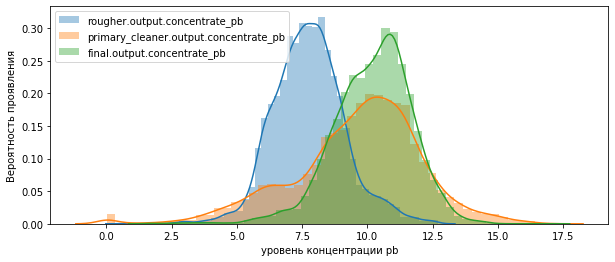

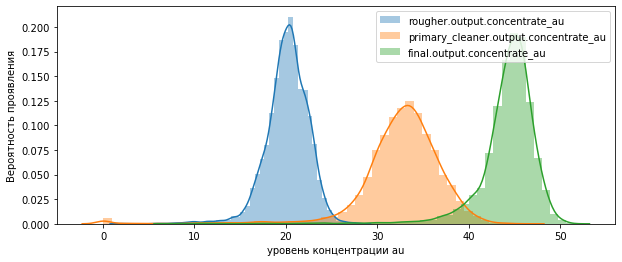

In [26]:
concentrate = {'ag':['rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag'],   
                'pb':['rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb'],   
                 'au':['rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au'] }   
# Посмотрим как меняется концентрация серебра на различных этапах очистки 

for key in concentrate:
    f, ax = plt.subplots(figsize=(10, 4))  
    for stage in concentrate[key]:
        sns.distplot(train_copy[stage],label = stage)
    ax.set(xlabel=f"уровень концентрации {key}",ylabel="Вероятность проявления")
    plt.legend()
    plt.show()   

<div class="alert alert-success">
    
**Комментарий ревьюера**
    
Визуализация супер)
</div>

``Серебро``
<br>Как мы видим на каждом этапе укровень концентрации серебра уменьшается. Оно и понятно, наша цель - получить больше золота. Так же есть пики в районе нуля, нужно будет их обработать дальше.

``Cвинец``
<br> Так же есть выбросы в районе нуля. Концентрация после флотации немного поднялась

``Золото``
<br> Так же есть выбросы в районе нуля. Но их меньше, чем в свинце и серебре. Отчетливо видно, что на каждом этапе поднимается концентрация, интересующего нас металла.

### Анализ распределения размеров гранул на обучающей и тестовой выборках

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

In [27]:
# найдем интересующие нас признаки
for column in train_copy.columns:
      if (column.find('feed_size'))!=-1:
            print(column)

primary_cleaner.input.feed_size
rougher.input.feed_size


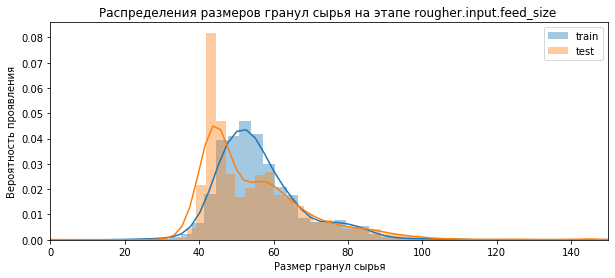

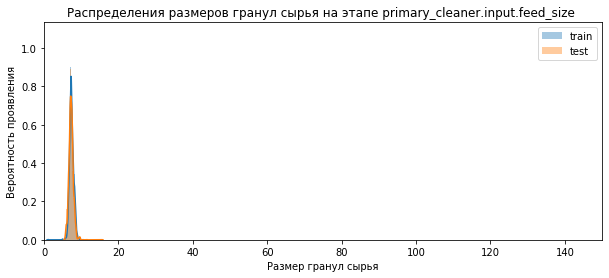

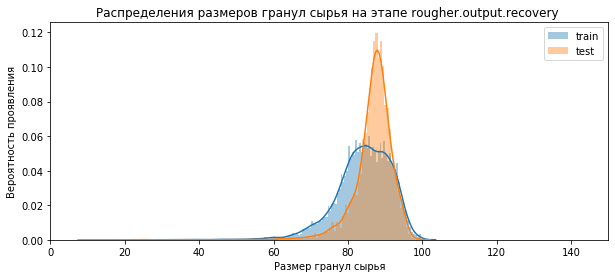

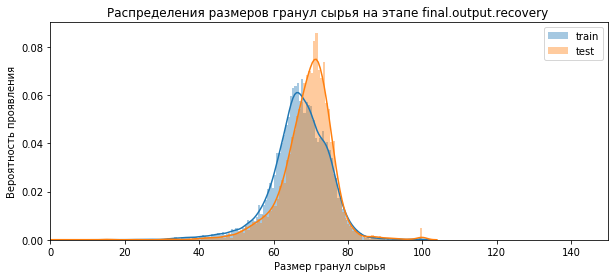

In [28]:
# Посмотрим на распределения размеров гранул сырья на обучающей и тестовой выборках 
#на этапах флотациии и первичной очистки

def feed_size(column):
    f, ax = plt.subplots(figsize=(10, 4))
    sns.distplot(train[column],bins=150,label='train');
    sns.distplot(test[column],bins=150,label='test');
    plt.legend()
    ax.set(xlim=(0, 150),xlabel='Размер гранул сырья',ylabel='Вероятность проявления',
           title=f'Распределения размеров гранул сырья на этапе {column} ' )
    plt.show()
    
    
feed_size('rougher.input.feed_size')
feed_size('primary_cleaner.input.feed_size')
feed_size('rougher.output.recovery')
feed_size('final.output.recovery')


На этапе первичной обработки с распределением гранул все впорядке. Но на этапе флотации, когда приходит сырье -видна разность распределений и средних в выборках. В трейне и тесте видны тяжелые хвосты, но на тесте он больше. Нужно задать вопрос тому кто давал данные, почему так поделили выборку на трейн и тест.

### Исследование суммарных концентраций

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [29]:
for column in train_copy.columns:
    for metall in ['au','ag','pb','sol']:        
        if (column.find(metall))!=-1:
            if column.find('output') > 0 and column.find('tail')==-1:
                print(column)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au


In [30]:
# посмотрим у скольки веществ измеряют конецентрацию
for column in train_copy.columns:
    if (column.find('state'))==-1 and column.find('concentrate')!=-1:
        for substance in ['au','ag','pb','sol']:
            if column.find(substance)!=-1: 
                print(column)
concentrate = {'ag':['rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag'],   
               'pb':['rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb'],   
               'au':['rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au'], 
               'sol':['rougher.output.concentrate_sol','primary_cleaner.output.concentrate_sol','final.output.concentrate_sol']}   

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au


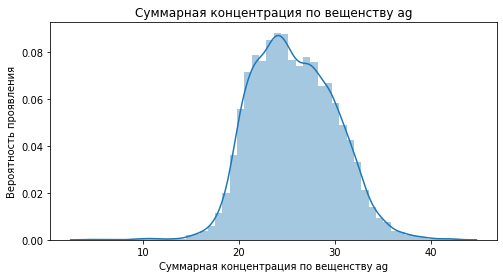

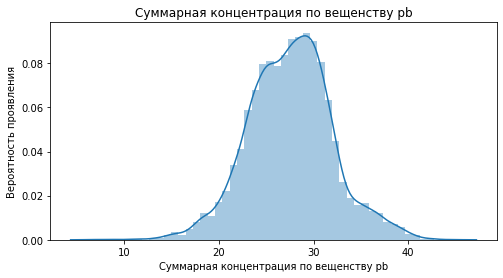

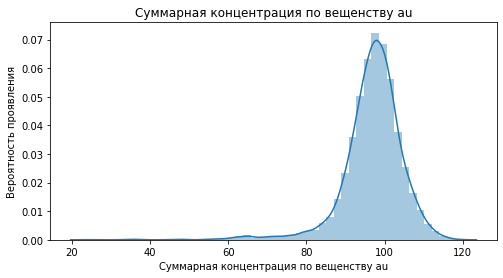

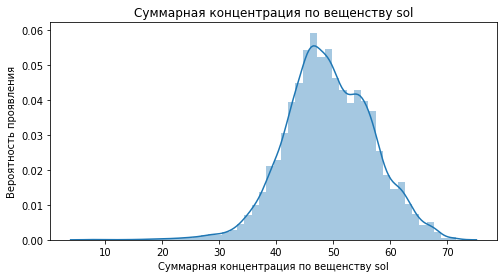

In [31]:
# посчитаем суммы концентраций метал
for key in concentrate:
    train_copy[key] = train_copy[concentrate[key][0]] +train_copy[concentrate[key][1]] +train_copy[concentrate[key][2]]
keys = list(concentrate.keys())

#построим диаграммы плотности распределений по концентрату каждого ведества
for key in keys:
    f, ax = plt.subplots(figsize=(8, 4))
    sns.distplot(train_copy[key])
    #sns.distplot(test[key])
    ax.set(xlabel=f'Суммарная концентрация по вещенству {key}',ylabel='Вероятность проявления',
           title=f'Суммарная концентрация по вещенству {key}' )
    plt.show()


Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

### Анализ и обработка аномальных значений

В данном случае нужно анализировать диапазон каждого признака и понимать тех. процесс, чтобы удалять признаки близкие к нулю. Поэтому мы не буедм удалять значения близкие к нулю для всего датафрэйма. Необходимы дополнительные консультации с аналитиками и экспертами в доменной облати. 

Как видим много коллинеарных признаков с состояниями, не будем пока принимать решение об удалении признаков.

## 3. Модель

### 3.1 Напишем функцию для вычисления итоговой sMAPE.

In [32]:
def sMAPE(actual,forecast):
    sMAPE= 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)
    return sMAPE
#actual = np.array([12, 13, 14, 15, 15,22, 27])
#forecast = np.array([11, 13, 14, 14, 15, 16, 18])
#sMAPE = 0.25*sMAPE(actual,forecast)+0.75*sMAPE(actual,forecast)
#print('{:.2f}'.format(sMAPE))

### 3.2 Обучим разные модели и оценим их качество кросс-валидацией. 

In [33]:
# перемешаем данные для модели
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [34]:
train.columns

Index(['rougher.input.floatbank11_xanthate',
       'rougher.state.floatbank10_e_level',
       'primary_cleaner.state.floatbank8_b_air',
       'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_d_level',
       'rougher.input.feed_au', 'secondary_cleaner.state.floatbank4_a_air',
       'rougher.input.feed_pb', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_d_air', 'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank10_sulfate',
       'secondary_cleaner.state.floatbank3_b_air',
       'primary_cleaner.state.floatbank8_d_level',
       'primary_cleaner.input.xanthate',
       'secondary_cleaner.state.floatbank4_b_level', 'rougher.input.feed_size',
       'primary_cleaner.state.floatbank8_d_air',
       'secondary_cleaner.state.floatbank6_a_air',
       'rougher.state.floatbank10_c_level',
       'rougher.input.floatbank11_sulfate',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
 

In [35]:
def smape_cross_final(df,model):
    no_rouher = filter(lambda x: x.find('rougher'),test.columns.to_list())
    rouher =  list(set(test.columns)-set(no_rouher))
    feature = df.drop(['secondary_cleaner.state.floatbank6_a_level','date','rougher.output.recovery','final.output.recovery']+rouher ,axis=1)
    target = df['final.output.recovery']
    return (abs(np.mean(cross_val_score(model, feature,target,scoring=make_scorer(sMAPE, greater_is_better=False), cv=5,n_jobs=-1))))

def smape_cross_rougher(df,model):
    no_rouher = filter(lambda x: x.find('rougher'),test.columns.to_list())
    no_rouher = list(no_rouher)
    feature = df.drop(['secondary_cleaner.state.floatbank6_a_level','date','final.output.recovery']+no_rouher ,axis=1)
    target = df['rougher.output.recovery']
    return (abs(np.mean(cross_val_score(model, feature,target,scoring=make_scorer(sMAPE, greater_is_better=False), cv=5,n_jobs=-1))))

In [36]:
#Посчитаем окончательное sMAPE 
def ultimate_sMAPE(model,type_model):
    sMAPE_rougher = smape_cross_rougher(train,model)
    sMAPE_final= smape_cross_final(train,model)
    print('sMAPE rougher для модели {} равно {}'.format(type_model,smape_cross_rougher(train,model)))
    print('sMAPE final для модели {} равно {:.2f}'.format(type_model,smape_cross_final(train,model)))
    print('Итоговое sMAPE  для модели {} равно {:.2f}'.format(type_model,(sMAPE_rougher*0.25 + sMAPE_final*0.75)))    

### Посмотрим на модели

In [37]:
%%time
model_LR = LinearRegression()
ultimate_sMAPE(model_LR,'LinearRegression')
print()

sMAPE rougher для модели LinearRegression равно 3.685167046407546e-14
sMAPE final для модели LinearRegression равно 7.27
Итоговое sMAPE  для модели LinearRegression равно 5.45

CPU times: user 1.99 s, sys: 2.45 s, total: 4.44 s
Wall time: 4.4 s


In [38]:
%%time
dummy_clf = DummyRegressor()
ultimate_sMAPE(dummy_clf,'DummyRegressor')
print()

sMAPE rougher для модели DummyRegressor равно 6.952636343180269
sMAPE final для модели DummyRegressor равно 8.93
Итоговое sMAPE  для модели DummyRegressor равно 8.43

CPU times: user 118 ms, sys: 39.5 ms, total: 157 ms
Wall time: 202 ms


Лучший результат показала линейная регрессия. Различные методы предобработки данных за исключением удаления явных нулей и пропусков не принесли результатов по улучшению метрик

In [39]:
# Проверим данные на тестовой выборке

In [40]:
def get_train_test_rougher():
    #no_rouher = filter(lambda x: x.find('rougher'),train.columns.to_list())
    #no_rouher = list(no_rouher)
    features_train = train.drop(['date','final.output.recovery','rougher.output.recovery'] ,axis=1)
    target_train = train['rougher.output.recovery']
    features_test = test.drop(['date','final.output.recovery','rougher.output.recovery'],axis=1)
    target_test = test['rougher.output.recovery']
    return features_train,target_train,features_test,target_test

def get_train_test_final():
    no_rouher = filter(lambda x: x.find('rougher'),train.columns.to_list())
    rouher =  list(set(test.columns)-set(no_rouher))
    features_train = train.drop(['secondary_cleaner.state.floatbank6_a_level','date','final.output.recovery']+rouher ,axis=1)
    target_train = train['final.output.recovery']
    features_test = test.drop(['secondary_cleaner.state.floatbank6_a_level','date','final.output.recovery']+rouher ,axis=1)
    target_test = test['final.output.recovery']
    return features_train,target_train,features_test,target_test

In [41]:
#упорядочим признаки, чтобы модель работала корректно
train = train.sort_index(axis=1)
test = test.sort_index(axis=1)

In [45]:
# посчитаем sMAPE для rougher
features_train,target_train,features_test,target_test = get_train_test_rougher()
model_LR_R = LinearRegression()
model_LR_R.fit(features_train,target_train)
predicted_test = model_LR_R.predict(features_test)
sMAPE_rougher = sMAPE(target_test,predicted_test)
print('rougher sMAPE',sMAPE_rougher)
model_LR_F = LinearRegression()
model_LR_F.fit(features_train,target_train)
predicted_test = model_LR_F.predict(features_test)
sMAPE_final = sMAPE(target_test,predicted_test)
print('Final sMAPE',sMAPE_final)

# посчитаем sMAPE для final
features_train,target_train,features_test,target_test = get_train_test_final()
print('Итоговое sMAPE   равно {:.2f}'.format((sMAPE_rougher*0.25 + sMAPE_final*0.75))) 

rougher sMAPE 4.797369886901789
Final sMAPE 4.797369886901789
Итоговое sMAPE   равно 4.80


## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке